In [ ]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **1. Loading the dataset**
This assignment will focus on the CIFAR10 dataset. This is a collection of small images in 10 classes such as cars, cats, birds, etc. You can find more information here: https://www.cs.toronto.edu/~kriz/cifar.html. We start by loading and examining the data.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

#### **<span style="color:red">Question 1:</span>**
The shape of X_train and X_test has 4 values. What do each of these represent?

Answer: The 5000 represents the number of pictures in the dataset (batchsize)
32, 32 is the dimensions of the picture with 32x32 pixels
3 is the number of color channels that each picture has, so red, green and blue color channels

##### **Plotting some images**
This plots a random selection of images from each class. Rerun the cell to see a different selection.

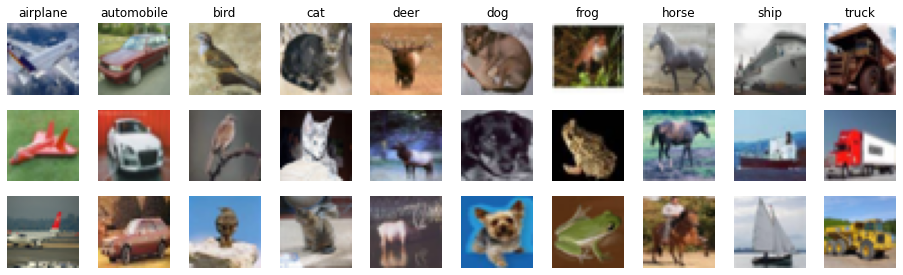

In [27]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)

##### **Preparing the dataset**
Just like the MNIST dataset we normalize the images to [0,1] and transform the class indices to one-hot encoded vectors.

In [ ]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### **2. Fully connected classifier**
We will start by creating a fully connected classifier using the ```Dense``` layer. We give you the first layer that flattens the image features to a single vector. Add the remaining layers to the network.

Consider what the size of the output must be and what activation function you should use in the output layer.

In [5]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

x_in = Input(shape=X_train.shape[1:])
x = Flatten()(x_in)

# === Add your code here ===
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(10, activation = 'softmax')(x)

# ==========================

model = Model(inputs=x_in, outputs=x)

# Now we build the model using Stochastic Gradient Descent with Nesterov momentum. We use accuracy as the metric.
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(100)

Model: "functional_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
flatten (Flatten)                            (None, 3072)                            0              
____________________________________________________________________________________________________
dense (Dense)                                (None, 128)                             393344         
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 64)                              8256           
_____________________________________________________________________

##### **Training the model**
In order to show the differences between models in the first parts of the assignment, we will restrict the training to the following command using 15 epochs, batch size 32, and 20% validation data. From section 5 and forward you can change this as you please to increase the accuracy, but for now stick with this command.

In [6]:
history = model.fit(X_train,y_train_c, epochs=15, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.8662 - accuracy: 0.3209 - val_loss: 1.7699 - val_accuracy: 0.3614
Epoch 2/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.7036 - accuracy: 0.3882 - val_loss: 1.7108 - val_accuracy: 0.3849
Epoch 3/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.6358 - accuracy: 0.4140 - val_loss: 1.6711 - val_accuracy: 0.4074
Epoch 4/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.6035 - accuracy: 0.4239 - val_loss: 1.6123 - val_accuracy: 0.4231
Epoch 5/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.5748 - accuracy: 0.4353 - val_loss: 1.6160 - val_accuracy: 0.4269
Epoch 6/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.5517 - accuracy: 0.4450 - val_loss: 1.6176 - val_accuracy: 0.4225
Epoch 7/15
1250/1250 [==============================] - 3s 3ms/step - loss: 1.5351 - accuracy: 0.4507 - val_loss: 1.6002 - val_accuracy:

##### **Evaluating the model**
We use ```model.evaluate``` to get the loss and metric scores on the test data. To plot the results we give you a custom function that does the work for you.

In [7]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.534
Test accuracy = 0.460


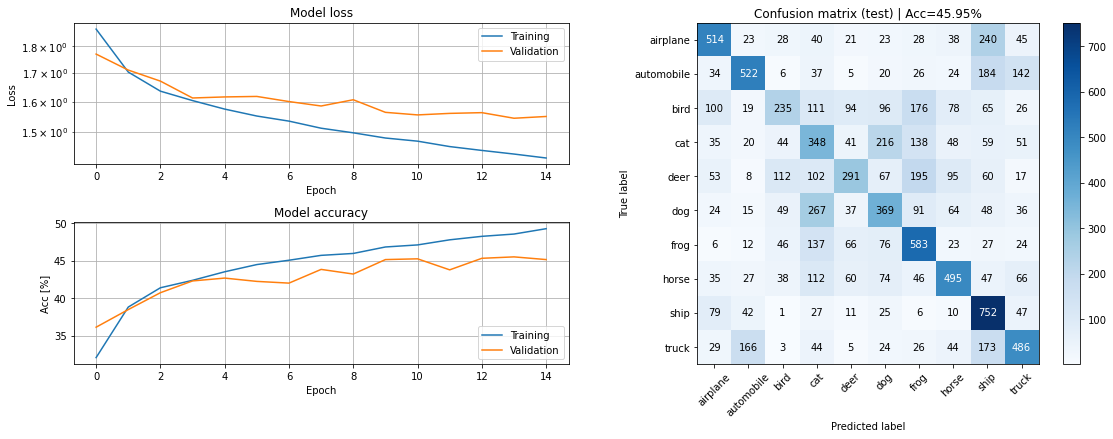

In [8]:
from Custom import PlotModelEval

# Custom function for evaluating the model and plotting training history
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 2:</span>**
Train a model that achieves above 45% accuracy on the test data. In the report, provide a (short) description of your model and show the evaluation image.

#### **<span style="color:red">Question 3:</span>**
Compare this model to the one you used for the MNIST dataset in the first assignment, in terms of size and test accuracy. Why do you think this dataset is much harder to classify than the MNIST handwritten digits?

### **3. CNN classifier**
We will now move on to a network architecture that is more suited for this problem, the convolutional neural network. The new layers you will use are ```Conv2D``` and ```MaxPooling2D```, which you can find the documentation of here https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D and here https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D.

##### **Creating the CNN model**

A common way to build convolutional neural networks is to create blocks of layers of the form **[convolution - activation - pooling]**, and then stack several of these block to create the full convolution stack. This is often followed by a fully connected network to create the output classes. Use this recipe to build a CNN that acheives at least 62% accuracy on the test data.

*Side note. Although this is a common way to build CNNs, it is be no means the only or even best way. It is a good starting point, but later in part 5 you might want to explore other architectures to acheive even better performance.*

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===
#conv1
conv2D_1=Conv2D(filters = 32,kernel_size = (3,3), padding = 'same', activation = 'relu')(x_in)
MaxPool2D_1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(conv2D_1)
#conv2
conv2D_2=Conv2D(filters = 64,kernel_size = (3,3), padding = 'same', activation = 'relu')(MaxPool2D_1)
MaxPool2D_L1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(conv2D_2)

Conv2D_3=Conv2D(filters = 128,kernel_size = (3,3), padding = 'same', activation = 'relu')(MaxPool2D_L1)
MaxP_3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(Conv2D_3)


# copied from prev q
x = Flatten()(MaxP_3)



# === dd your code here ===
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(10, activation = 'softmax')(x)



 

# ==========================


model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

ModuleNotFoundError: No module named 'tensorflow'

##### **Training the CNN**

In [41]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
 169/1250 [===>..........................] - ETA: 4:02 - loss: 2.1856 - accuracy: 0.1812

KeyboardInterrupt: 

##### **Evaluating the CNN**

In [25]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 2.449
Test accuracy = 0.612


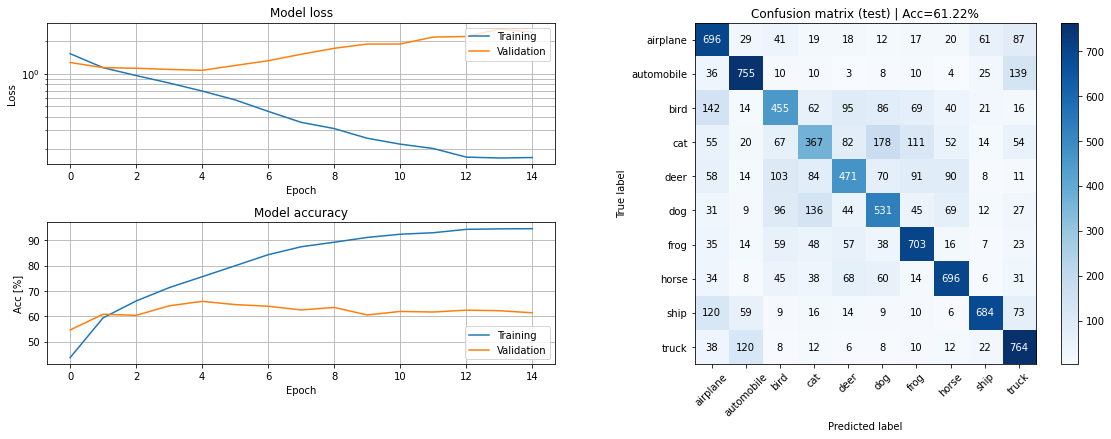

In [26]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 4:</span>**
Train a model that achieves at least 62% test accuracy. In the report, provide a (short) description of your model and show the evaluation image.

ANSWER:

The neural network contains three convolutional layers with the activation function relu, the kernel size used for convolution is a  (3x3) matrix. Each convoultion layer is followed by a pooling function where the pooling is set to a "window" of (2x2) matrix. Where it will take the highest pixel-value in each "window". The strides or stepsize of which the window moves is (1x1). The filters of each of the convultions goes from simple to more complex with the values: 32,64, 128.

Then the output is flattened into a single vector and used as input into the fully connected classifier with two layer network with relu as activation and 64 and 32 neurons each. The output layer uses softmax activation and has 10 neurons which corresponds to the number of classes. 

#### **<span style="color:red">Question 5:</span>**
Compare this model with the previous fully connected model. You should find that this one is much more efficient, i.e. achieves higher accuracy with fewer parameters. Explain in your own words how this is possible.

The combination of convolution - activation - pooling is can be seen as the feature learning phase of the neural network. Where  network tries to learn the primitive image features as edges and lines of the dataset which will provide as kind of preprocessing for the neural network to improve the input into the fully connected network. The convoulution layer detects particular features depending on the kernel used. These multiple features are pooled together in the maxpooling phase which combines the maximum pixel values in the defined pooling window (in our case, window is a 2X2 matrix). Because of this preprocessing arrangement we get more abstract features as input to the fully connected classifier, hence we see a better result.

### **4. Regularization**

#### **4.1 Dropout**
You have probably seen that your CNN model overfits the training data. One way to prevent this is to add ```Dropout``` layers to the model, that randomly "drops" hidden nodes each training-iteration by setting their output to zero. Thus the model cannot rely on a small set of very good hidden features, but must instead learns to use different sets of hidden features each time. Dropout layers are usually added after the pooling layers in the convolution part of the model, or after activations in the fully connected part of the model.

*Side note. In the next assignment you will work with Ensemble models, a way to use the output from several individual models to achieve higher performance than each model can achieve on its own. One way to interpret Dropout is that each random selection of nodes is a separate model that is trained only on the current iteration. The final output is then the average of outputs from all the individual models. In other words, Dropout can be seen as a way to build ensembling directly into the network, without having to train several models explicitly.*

Extend your previous model with the Dropout layer and test the new performance.

In [36]:
from tensorflow.keras.layers import Dropout

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

Conv2D_1=Conv2D(filters = 32,kernel_size = (3,3), padding = 'same', activation = 'relu')(x_in)
MaxP_1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(Conv2D_1)
Drop_1=Dropout(0.3)(MaxP_1)

#conv2
Conv2D_2=Conv2D(filters = 64,kernel_size = (3,3), padding = 'same', activation = 'relu')(Drop_1)
MaxP_2 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(Conv2D_2)
Drop_2=Dropout(0.3)(MaxP_2)

Conv2D_3=Conv2D(filters = 128,kernel_size = (3,3), padding = 'same', activation = 'relu')(Drop_2)
MaxP_3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(Conv2D_2)
Drop_3=Dropout(0.3)(MaxP_3)

# copied from prev q
x = Flatten()(Drop_3)



# === dd your code here ===
x = Dense(128, activation = 'relu')(x)
x=Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)
x=Dropout(0.3)(x)

x = Dense(10, activation = 'softmax')(x)

# ==========================

model = Model(inputs=x_in, outputs=x)

# Compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

Model: "functional_21"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_18 (InputLayer)                        [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_23 (Conv2D)                           (None, 32, 32, 32)                      896            
____________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D)              (None, 32, 32, 32)                      0              
____________________________________________________________________________________________________
dropout_14 (Dropout)                         (None, 32, 32, 32)                      0              
____________________________________________________________________

In [37]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
 199/1250 [===>..........................] - ETA: 1:55 - loss: 2.1692 - accuracy: 0.1814

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 6:</span>**
Train the modified CNN-model. Save the evaluation image for the report.

#### **<span style="color:red">Question 7:</span>**
Compare this model and the previous in terms of the training accuracy, validation accuracy, and test accuracy. Explain the similarities and differences (remember that the only difference between the models should be the addition of Dropout layers).

Hint: what does the dropout layer do at test time?

|          | training | validation | test  |
| -------- | -------- | ---------- | ----- |
| CNN      | 0.9388   | 0.6414     | 0.632 |
| CNN-drop | 0.6087   | 0.5933     | 0.592 |


The training accuracy is much higher in the CNN without drop compared to the one with. Using drop training validation and test have a similar accuracy. The difference in training to validation and test accuracy for the CNN without drop is because the model overfits the data for the training because a lack of regularization. By introducing the drop functionality the model generalizes better as  and becomes less sensitive to the data, hence does not overfit.

#### **4.2 Batch normalization**
The final layer we will explore is ```BatchNormalization```. As the name suggests, this layer normalizes the data in each batch to have a specific mean and standard deviation, which is learned during training. The reason for this is quite complicated (and still debated among the experts), but suffice to say that it helps the optimization converge faster which means we get higher performance in fewer epochs. The normalization is done separatly for each feature, i.e. the statistics are calculated accross the batch dimension of the input data. The equations for batch-normalizing one feature are the following, where $N$ is the batch size, $x$ the input features, and $y$ the normalized output features:

$$ \mu = \frac{1}{N} \sum_{i=0}^{N}x_i,\;\;\;\; \sigma^2 = \frac{1}{N} \sum_{i=0}^{N}(x_i - \mu)^2 $$

$$ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $$

$$ y_i = \gamma \hat{x}_i + \beta $$

At first glance this might look intimidating, but all it means is that we begin by scaling and shifting the data to have mean $\mu=0$ and standard deviation $\sigma=1$. After this we use the learnable parameters $\gamma$ and $\beta$ to decide the width and center of the final distribution. $\epsilon$ is a small constant value that prevents the denominator from being zero.

In addition to learning the parameters $\gamma$ and $\beta$ by gradient decent just like the weights, Batch Normalization also keeps track of the running average of minibatch statistics $\mu$ and $\sigma$. These averages are used to normalize the test data. We can tune the rate at which the running averages are updated with the *momentum* parameter of the BatchNormalization layer. A large momentum means that the statistics converge more slowly and therefore requires more updates before it represents the data. A low momentum, on the other hand, adapts to the data more quickly but might lead to unstable behaviour if the latest minibatches are not representative of the whole dataset. For this test we recommend a momentum of 0.75, but you probably want to change this when you design a larger network in Section 5.

The batch normalization layer should be added after the hidden layer linear transformation, but before the nonlinear activation. This means that we cannot specify the activation funciton in the ```Conv2D``` or ```Dense``` if we want to batch-normalize the output. We therefore need to use the ```Activation``` layer to add a separate activation to the network stack after batch normalization. For example, the convolution block will now look like **[conv - batchnorm - activation - pooling]**.

Extend your previous model with batch normalization, both in the convolution and fully connected part of the model.

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=25, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 8:</span>**
Train the model and save the evaluation image for the report.

#### **<span style="color:red">Question 9:</span>**
When using BatchNorm one must take care to select a good minibatch size. Describe what problems might arise if the wrong minibatch size is used.

You can reason about this given the description of BatchNorm above, or you can search for the information in other sources. Do not forget to provide links to the sources if you do!

Batch Normalization keeps track of the running average of minibatch statistics $\mu$ and $\sigma$ later these averages are used to normalize the test data. If we choose a small minbatch size, there is a high chance that the sample statistics calculated using the data samples within that batch might not represent the overall statistics. For example: If we select the minbatch size as 1 
In addition, if we use a large batchsize then there would small number of batches that could be used to learn the statistics for batchnormalization.


###

    

In batch normalization, the parameters $\mu$ and standard deviation $\sigma$ are calculated from the input batch. These values are updated based on the momentum parameter we set. The final mean and standard deviations are calculated from the last batch and values are stored in the model. When we use the model to run over the test data, these parameters are reused from the training phase and not learnt over the test data. 

Now, if the batch size is very small, then the $\mu$ and $\sigma$ calculated are not sufficient statistics hence the results might not be stable when we use a large batch/no batch in the testing phase. Because, our $\mu$ value would be very small and there would not be efficient normalization. 


### the one to use

When using BatchNorm one must take care to select a good minibatch size. Describe what problems might arise if the wrong minibatch size is used.

You can reason about this given the description of BatchNorm above, or you can search for the information in other sources. Do not forget to provide links to the sources if you do!

As its mentioned in the description of Batch Normalization above, the batch size we select should contain the data points that represent the whole dataset, there by to calculate optimal statistics. In addition, from equations provided above, if the batch size = 1, then the normalized output will be zero. Hence the batch size should be always >1. Now if batch sizes are smaller, chances that the samples representing whole dataset is very less hence algorithm might update the noisy parameters, which is good in a way as we can have better regularization. There is another possibility of frequent skipping of unfavourable local minima if the batch sizes are smaller because of noisy updates. On the other hand, for the large batch size, the parameter updates are closer to the actual gradient and less regularization.(Ref:https://kth.diva-portal.org/smash/get/diva2:955562/FULLTEXT01.pdf)
(1 liked)

### **5. Putting it all together**
We now want you to create your own model based on what you have learned. We want you to experiment and see what works and what doesn't, so don't go crazy with the number of epochs until you think you have something that works.

To pass this assignment, we want you to acheive **75%** accuracy on the test data in no more than **25 epochs**. This is possible using the layers and techniques we have explored in this notebook, but you are free to use any other methods that we didn't cover. (You are obviously not allowed to cheat, for example by training on the test data.)

In [ ]:
from tensorflow.keras.utils import plot_model

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 10:</span>**
Design and train a model that achieves at least 75% test accuracy in at most 25 epochs. Save the evaluation image for the report. Also, in the report you should explain your model and motivate the design choices you have made.



The design of the model is an extension of the previous model from CNN now with 4 convuloutional layers with 32,64,128 and 256 filters each. The chosen paramaters are as for previous models. After each convolutional layer batchnormalization is performed with 32 as the min-batchsize. Then activation with relu is used followed by pooling as the same as before. After each pass through the steps of convolution - batchnormalization - activation -pooling there is a drop function called with the probability of 30% that the results calculated will not be used and previous results will be sent forward to the next part of the network.

For the fully connected part the neural network layers contained 128, 64 neurons. After each layer batchnormalization is applied and the drop function is called. As previous the output layer uses softmax as activation with 10 neurons. 

This model achived in 20 epochs:

Test loss = 0.741
Test accuracy = 0.756

The addition of batch normalization is to increase the speed of convergence of the network and the drop function is included for regularization such that the model will avoid overfitting on the data. From trial and error we found adding another learning layer and increasing the number of nerons in the fully connected neural network increased both the training and test accuracy. Addding another feature learning layer increased the abstraction of the image features and provide better input for the fully connected part. Implementing batchNormalization in the network after each convolution increases the speed of convergence of the network and the drop function is included for regularization such that the model will avoid overfitting on the data. Increasing the number of neurons in the fully connected part to the model increases the number of non-linear operations which improves the classification.

### **Want some extra challenge?**
For those of you that feel the competitive spark right now, we will hold an **optional** competition where you can submit your trained model-file for evaluation. To make this fair, you are not allowed to train for more than **50 epochs**, but other than that we want you to get creative. The competition is simple, we will evaluate all submitted models and the model with highest test accuracy wins. The prize is nothing less than eternal glory.

Here are some things to look into, but note that we don't have the answers here. Any of these might improve the performance, or might not, or it might only work in combination with each other. This is up to you to figure out. This is how deep learning research often happens, trying things in a smart way to see what works best.
* Tweak or change the optimizer or training parameters.
* Tweak the filter parameters, such as numbers and sizes of filters.
* Use other activation functions.
* Add L1/L2 regularization (see https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
* Include layers that we did not cover here (see https://www.tensorflow.org/api_docs/python/tf/keras/layers). For example, our best model uses the global pooling layers.
* Take inspiration from some well-known architectures, such as ResNet or VGG16. (But don't just copy-paste those architectures. For one, what's the fun in that? Also, they take a long time to train, you will not have time.)
* Use explicit model ensembing (training multiple models that vote on or average the outputs - this will also take a lot of time.)
* Use data augmentation to create a larger training set (see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Write your competition model here. This way you can try different things without deleting the model you created above. Also set the GroupName variable to your LiU IDs or some unique name; that way our scripts can be a lot easier, thanks and good luck :)

In [ ]:
GroupName = "Test"

x_in = Input(shape=X_train.shape[1:])

# Your code here

model = Model(inputs=x_in, outputs=x, name=GroupName)

# You can also change this if you want
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

# Print the summary and model image
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

**Don't forget to save your model!**

In [ ]:
model.save("CompetionModel_" + GroupName + ".h5")